## 注意⼒汇聚：Nadaraya-Watson 核回归
上节介绍了框架下的注意⼒机制的主要成分 图10.1.3：查询（⾃主提⽰）和键（⾮⾃主提⽰）之间的交互形成
了注意⼒汇聚；注意⼒汇聚有选择地聚合了值（感官输⼊）以⽣成最终的输出。本节将介绍注意⼒汇聚的更
多细节，以便从宏观上了解注意⼒机制在实践中的运作⽅式。具体来说，1964年提出的Nadaraya-Watson核
回归模型是⼀个简单但完整的例⼦，可以⽤于演⽰具有注意⼒机制的机器学习。


In [13]:
import torch
from torch import nn
from d2l import torch as d2l


### 生成数据集
简单起⻅，考虑下⾯这个回归问题：给定的成对的“输⼊－输出”数据集 {(x1, y1), . . . ,(xn, yn)}，如何学习f来
预测任意新输⼊x的输出yˆ = f(x)？

根据下⾯的⾮线性函数⽣成⼀个⼈⼯数据集，其中加⼊的噪声项为ϵ：

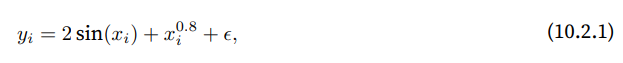  

其中ϵ服从均值为0和标准差为0.5的正态分布。在这⾥⽣成了50个训练样本和50个测试样本。为了更好地可视
化之后的注意⼒模式，需要将训练样本进⾏排序。

In [5]:
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本
print(x_train)
print(_)


tensor([0.0873, 0.1657, 0.1796, 0.3354, 0.4060, 0.5920, 0.6188, 0.7513, 0.8450,
        0.9252, 0.9895, 1.1179, 1.1269, 1.1477, 1.4074, 1.4765, 1.5780, 1.7792,
        1.9821, 2.3758, 2.3967, 2.4479, 2.4942, 2.5916, 2.6699, 2.7390, 2.7473,
        2.8496, 2.8725, 2.9518, 2.9559, 3.1388, 3.1566, 3.1851, 3.2812, 3.3004,
        3.3921, 3.3949, 3.4350, 3.4936, 3.4939, 3.5923, 3.7519, 3.8064, 4.4100,
        4.4317, 4.4374, 4.5114, 4.7851, 4.9773])
tensor([49, 35,  4, 20, 29, 17,  7, 38, 47, 14,  9, 36, 22, 44, 25, 33, 43, 45,
         0, 30, 12,  5, 41, 18, 15, 21,  3, 11, 34, 24, 48, 40,  2, 37,  8, 46,
        23, 26, 27, 13,  1, 19, 39, 10, 16, 28, 31,  6, 42, 32])


In [7]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

#torch.normal() 是一个用于生成服从正态分布的随机数的函数。
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数
n_test


50

下⾯的函数将绘制所有的训练样本（样本由圆圈表⽰），不带噪声项的真实数据⽣成函数f（标记为“Truth”），
以及学习得到的预测函数（标记为“Pred”）。

In [8]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
            xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);


### 平均汇聚
先使⽤最简单的估计器来解决回归问题。基于平均汇聚来计算所有训练样本输出值的平均值：

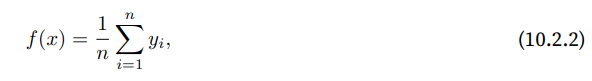  

如下图所⽰，这个估计器确实不够聪明。真实函数f（“Truth”）和预测函数（“Pred”）相差很⼤。


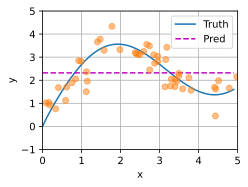

In [9]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 非参数注意力汇聚
显然，平均汇聚忽略了输⼊xi。于是Nadaraya (Nadaraya, 1964)和 Watson (Watson, 1964)提出了⼀个更好的
想法，根据输⼊的位置对输出yi进⾏加权：  
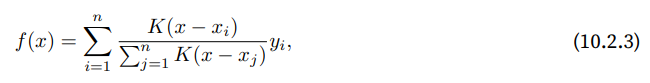

其中K是核（kernel）。公式 (10.2.3)所描述的估计器被称为 Nadaraya-Watson核回归（Nadaraya-Watson kernel
regression）。这⾥不会深⼊讨论核函数的细节，但受此启发，我们可以从 图10.1.3中的注意⼒机制框架的⻆
度重写 (10.2.3)，成为⼀个更加通⽤的注意⼒汇聚（attention pooling）公式：

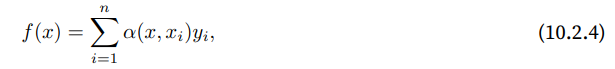

其中x是查询，(xi
, yi)是键值对。⽐较 (10.2.4)和 (10.2.2)，注意⼒汇聚是yi的加权平均。将查询x和键xi之间的
关系建模为 注意⼒权重（attention weight）α(x, xi)，如 (10.2.4)所⽰，这个权重将被分配给每⼀个对应值yi。
对于任何查询，模型在所有键值对注意⼒权重都是⼀个有效的概率分布：它们是⾮负的，并且总和为1。

为了更好地理解注意⼒汇聚，下⾯考虑⼀个⾼斯核（Gaussian kernel），其定义为：

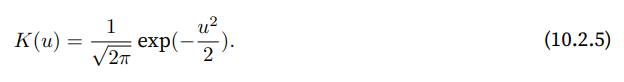

将⾼斯核代⼊ (10.2.4)和 (10.2.3)可以得到：

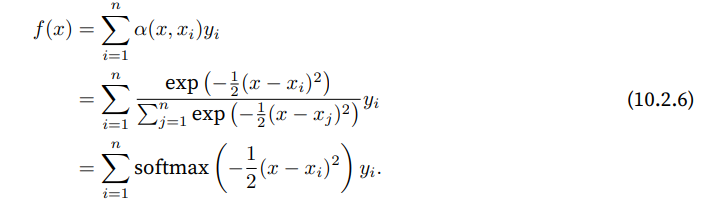

在 (10.2.6)中，如果⼀个键xi越是接近给定的查询x，那么分配给这个键对应值yi的注意⼒权重就会越⼤，也
就“获得了更多的注意⼒”。

值得注意的是，Nadaraya-Watson核回归是⼀个⾮参数模型。因此，(10.2.6)是 ⾮参数的注意⼒汇聚
（nonparametric attention pooling）模型。接下来，我们将基于这个⾮参数的注意⼒汇聚模型来绘制预测
结果。从绘制的结果会发现新的模型预测线是平滑的，并且⽐平均汇聚的预测更接近真实。

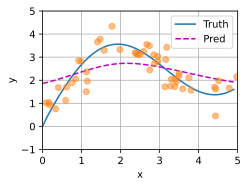

In [10]:
# X_repeat的形状:(n_test,n_train),
# 每⼀⾏都包含着相同的测试输⼊（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每⼀⾏都包含着要在给定的每个查询的值（y_train）之间分配的注意⼒权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)

# y_hat的每个元素都是值的加权平均值，其中的权重是注意⼒权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)


现在来观察注意⼒的权重。这⾥测试数据的输⼊相当于查询，⽽训练数据的输⼊相当于键。因为两个输⼊都
是经过排序的，因此由观察可知“查询-键”对越接近，注意⼒汇聚的注意⼒权重就越⾼。

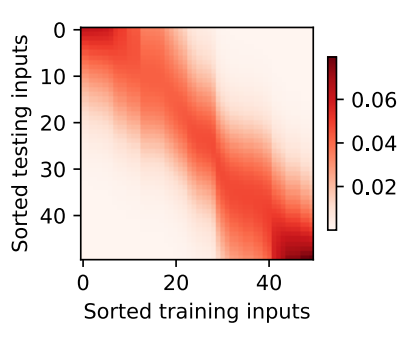

### 带参数注意力汇聚
⾮参数的Nadaraya-Watson核回归具有⼀致性（consistency）的优点：如果有⾜够的数据，此模型会收敛到
最优结果。尽管如此，我们还是可以轻松地将可学习的参数集成到注意⼒汇聚中。

例如，与 (10.2.6)略有不同，在下⾯的查询x和键xi之间的距离乘以可学习参数w：  
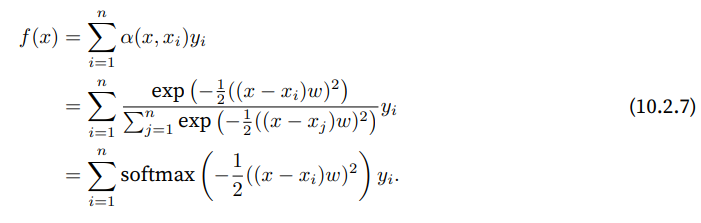

本节的余下部分将通过训练这个模型 (10.2.7)来学习注意⼒汇聚的参数。

#### 批量矩阵乘法
为了更有效地计算⼩批量数据的注意⼒，我们可以利⽤深度学习开发框架中提供的批量矩阵乘法。

假设第⼀个⼩批量数据包含n个矩阵X1, . . . , Xn，形状为a × b，第⼆个⼩批量包含n个矩阵Y1, . . . , Yn，形状
为b × c。它们的批量矩阵乘法得到n个矩阵 X1Y1, . . . , XnYn，形状为a × c。因此，假定两个张量的形状分别
是(n, a, b)和(n, b, c)，它们的批量矩阵乘法输出的形状为(n, a, c)。


In [17]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意⼒机制的背景中，我们可以使⽤⼩批量矩阵乘法来计算⼩批量数据中的加权平均值。

In [18]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))


tensor([[[ 4.5000]],

        [[14.5000]]])

#### 定义模型
基于 (10.2.7)中的带参数的注意⼒汇聚，使⽤⼩批量矩阵乘法，定义Nadaraya-Watson核回归的带参数版本为：



In [19]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                            values.unsqueeze(-1)).reshape(-1)


#### 训练
接下来，将训练数据集变换为键和值⽤于训练注意⼒模型。在带参数的注意⼒汇聚模型中，任何⼀个训练样
本的输⼊都会和除⾃⼰以外的所有训练样本的“键－值”对进⾏计算，从⽽得到其对应的预测输出。

In [20]:
# X_tile的形状:(n_train，n_train)，每⼀⾏都包含着相同的训练输⼊
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每⼀⾏都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意⼒汇聚模型时，使⽤平⽅损失函数和随机梯度下降。


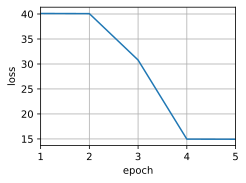

In [22]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所⽰，训练完带参数的注意⼒汇聚模型后可以发现：在尝试拟合带噪声的训练数据时，预测结果绘制的
线不如之前⾮参数模型的平滑。


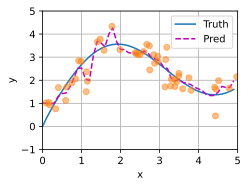

In [23]:
# keys的形状:(n_test，n_train)，每⼀⾏包含着相同的训练输⼊（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)


为什么新的模型更不平滑了呢？下⾯看⼀下输出结果的绘制图：与⾮参数的注意⼒汇聚模型相⽐，带参数的
模型加⼊可学习的参数后，曲线在注意⼒权重较⼤的区域变得更不平滑。

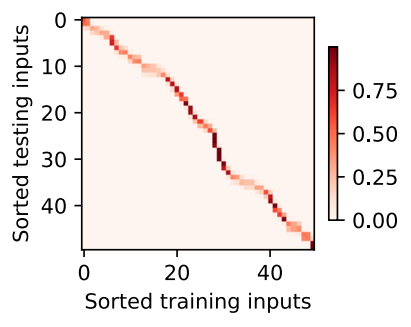

## 小结
* Nadaraya-Watson核回归是具有注意⼒机制的机器学习范例。
* Nadaraya-Watson核回归的注意⼒汇聚是对训练数据中输出的加权平均。从注意⼒的⻆度来看，分配给每个值的注意⼒权重取决于将值所对应的键和查询作为输⼊的函数。
* 注意⼒汇聚可以分为⾮参数型和带参数型。
